In [1]:
import argparse
import os
import pickle
import shutil

import sklearn.metrics as metrics
import torch
from tensorboardX import SummaryWriter

import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain
import sys

In [2]:
import pickle
import torch
from tensorboardX import SummaryWriter
import models
import utils.io_utils as io_utils
import utils.parser_utils as parser_utils
from explainer import explain


# Step 1: Argument Parsing (based on your explainer_main.py setup)
def arg_parse():
    # Check if we are in a Jupyter notebook environment

    # Manually set the arguments for notebook usage
    class Args:
        dataset = "synthetic"
        bmname = "synthetic"
        pkl_fname = None
        logdir = "log"
        ckptdir = "ckpt"
        cuda = "0"
        gpu = False
        num_epochs = 100
        hidden_dim = 20
        output_dim = 20
        num_gc_layers = 3
        dropout = 0.01
        mask_act = "sigmoid"
        explain_node = None
        graph_idx = -1
        graph_mode = True  # Graph classification mode
        align_steps = 1000
        opt = "adam"
        opt_scheduler = "none"
        method = "base"  # Method attribute was missing
        name_suffix = ""
        explainer_suffix = ""
        clip = 2.0
        lr = 0.1
        batch_size = 20
        bias = True
        clean_log = False
        bn = False
        mask_bias = False

    return Args()


# Step 2: Function to Initialize Explainer and Model
def initialize_explainer():
    # Load the arguments
    prog_args = arg_parse()

    if prog_args.gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = prog_args.cuda
        print("Using GPU")
    else:
        print("Using CPU")

    # Load a model checkpoint
    ckpt = io_utils.load_ckpt(prog_args)
    cg_dict = ckpt["cg"]  # get computation graph

    input_dim = cg_dict["feat"].shape[2]
    num_classes = cg_dict["pred"].shape[2]

    print("Loaded model from checkpoint")
    print("Input dim:", input_dim, "; Num classes:", num_classes)

    # Build the model
    if prog_args.graph_mode:
        model = models.GcnEncoderGraph(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )
    else:
        model = models.GcnEncoderNode(
            input_dim=input_dim,
            hidden_dim=prog_args.hidden_dim,
            embedding_dim=prog_args.output_dim,
            label_dim=num_classes,
            num_layers=prog_args.num_gc_layers,
            bn=prog_args.bn,
            args=prog_args,
        )

    # Load the model state
    model.load_state_dict(ckpt["model_state"])

    # Initialize the explainer
    explainer = explain.Explainer(
        model=model,
        adj=cg_dict["adj"],
        feat=cg_dict["feat"],
        label=cg_dict["label"],
        pred=cg_dict["pred"],
        train_idx=cg_dict["train_idx"],
        args=prog_args,
        writer=None,  # No Tensorboard logging for simplicity
        print_training=True,
        graph_mode=prog_args.graph_mode,
        graph_idx=prog_args.graph_idx,
    )

    return explainer


# Step 3: Prototype Extraction Function
import torch
import numpy as np


# Function to extract prototype (non-masked nodes and features)
def extract_prototype(graph_idx, explainer):
    """
    Extract and save the prototype for a given graph.

    Args:
        graph_idx: Index of the graph to explain
        explainer: The explainer instance used to generate explanations

    Returns:
        prototype: A dictionary containing important nodes and their corresponding important features
    """
    print(f"Explaining graph {graph_idx}...")

    # Explain the graph and get the masked adjacency matrix
    masked_adj = explainer.explain(node_idx=0, graph_idx=graph_idx, graph_mode=True)

    # If masked_adj is a numpy array, convert it to a tensor
    if isinstance(masked_adj, np.ndarray):
        masked_adj = torch.tensor(masked_adj)

    # Get feature mask if available
    mask_feat = explainer.mask_feat if hasattr(explainer, "mask_feat") else None

    # Retain only the non-masked nodes (summing over axis 1 to get the importance of each node)
    node_importance = masked_adj.sum(dim=1)  # Sum over rows to get node importance
    important_nodes = torch.nonzero(
        node_importance > 0
    ).squeeze()  # Keep important nodes

    # Retain only non-masked features for important nodes
    important_features = explainer.feat[important_nodes]
    if mask_feat is not None:
        important_features = important_features * mask_feat[important_nodes]

    # Prepare the prototype data
    prototype = {
        "important_nodes": important_nodes.cpu().numpy(),
        "important_features": important_features.cpu().numpy(),
    }

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype

    # Save the prototype to a file
    prototype_file = f"prototype_graph_{graph_idx}.pkl"
    with open(prototype_file, "wb") as f:
        pickle.dump(prototype, f)

    print(f"Prototype for graph {graph_idx} saved to {prototype_file}.")
    return prototype


# Initialize the explainer
explainer = initialize_explainer()

# Step 4: Generate prototypes for test graphs (replace with your test graph indices)
test_graph_indices = [0, 1, 2, 3]  # Example test graph indices

# Extract prototypes
for graph_idx in test_graph_indices:
    prototype = extract_prototype(graph_idx, explainer)
    print(prototype)
    print(f"Prototype for graph {graph_idx}: {prototype}")

Using CPU
loading model
ckpt/synthetic_base_h20_o20.pth.tar
=> loading checkpoint 'ckpt/synthetic_base_h20_o20.pth.tar'
Loaded model from checkpoint
Input dim: 4 ; Num classes: 360
Explaining graph 0...
Graph predicted label:  1


/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


epoch:  0 ; loss:  39.55552291870117 ; mask density:  0.7524133920669556 ; pred:  tensor([2.1503e-01, 1.4023e-01, 2.1324e-01, 4.0989e-01, 7.6297e-05, 5.7141e-05,
        5.6709e-05, 6.4032e-05, 6.6360e-05, 4.6878e-05, 7.2689e-05, 6.7245e-05,
        6.1787e-05, 6.0338e-05, 7.4298e-05, 5.7239e-05, 6.2693e-05, 5.5576e-05,
        5.7981e-05, 5.3903e-05, 6.9213e-05, 7.6418e-05, 6.5637e-05, 5.3593e-05,
        6.5272e-05, 7.6074e-05, 6.4349e-05, 5.4766e-05, 4.7131e-05, 5.4671e-05,
        6.6646e-05, 6.8913e-05, 9.6186e-05, 5.4541e-05, 4.3626e-05, 6.9667e-05,
        6.6404e-05, 6.0149e-05, 7.0544e-05, 7.1743e-05, 7.7199e-05, 7.0935e-05,
        5.3796e-05, 6.0360e-05, 7.1488e-05, 6.6695e-05, 6.6789e-05, 8.5799e-05,
        5.5992e-05, 5.3411e-05, 5.2089e-05, 5.6957e-05, 5.5204e-05, 6.1475e-05,
        5.9508e-05, 7.7074e-05, 5.1476e-05, 6.5812e-05, 5.2594e-05, 5.4130e-05,
        5.0323e-05, 5.6954e-05, 7.3990e-05, 4.8631e-05, 5.0540e-05, 4.8823e-05,
        5.2878e-05, 6.7245e-05, 7.9639

/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


tensor([1.2974e-01, 6.7788e-01, 7.0725e-02, 8.9816e-02, 8.8580e-05, 9.4515e-05,
        9.5081e-05, 9.8904e-05, 1.1430e-04, 6.3208e-05, 8.6040e-05, 9.8581e-05,
        8.8209e-05, 9.5987e-05, 1.1245e-04, 9.8194e-05, 8.1306e-05, 7.4506e-05,
        9.0855e-05, 8.0229e-05, 1.0577e-04, 1.0260e-04, 9.5460e-05, 7.3915e-05,
        1.0003e-04, 1.0386e-04, 1.0295e-04, 1.0581e-04, 6.1608e-05, 7.3902e-05,
        9.6300e-05, 1.0976e-04, 1.1937e-04, 1.0079e-04, 6.6668e-05, 1.1020e-04,
        9.3583e-05, 6.7407e-05, 1.1819e-04, 1.1083e-04, 9.4252e-05, 9.4572e-05,
        7.6387e-05, 8.2768e-05, 7.8829e-05, 1.0908e-04, 1.0897e-04, 1.0904e-04,
        7.4917e-05, 7.5754e-05, 8.1582e-05, 7.2158e-05, 7.1556e-05, 9.3503e-05,
        8.3950e-05, 1.1195e-04, 9.2819e-05, 1.0182e-04, 8.7960e-05, 8.9097e-05,
        7.4235e-05, 9.0781e-05, 1.0132e-04, 7.6688e-05, 7.7235e-05, 6.4348e-05,
        8.7863e-05, 1.1091e-04, 1.0333e-04, 1.1282e-04, 9.0782e-05, 8.5442e-05,
        9.4473e-05, 8.5213e-05, 7.8208e-

In [3]:
from dataset import GraphDataset, create_dataset

pyg_dataset = pyg_dataset = GraphDataset(
    torch.load("my_data/cycle_line_star_complete_1.pt", weights_only=False)
)

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

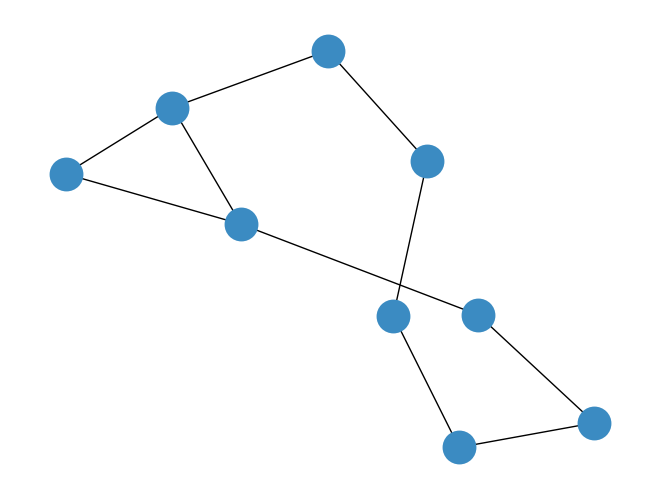

/Users/tsimiho/Desktop/NTUA/ECE/AILS/DiplomaThesis/Code/repo/gmn/prototypes/gnn-model-explainer/explainer/explain.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long)


Graph predicted label:  3
epoch:  0 ; loss:  39.18804168701172 ; mask density:  0.7500689029693604 ; pred:  tensor([2.2534e-01, 2.0205e-01, 2.0294e-01, 3.4429e-01, 8.4402e-05, 6.8487e-05,
        6.6520e-05, 7.6655e-05, 8.2721e-05, 5.6973e-05, 8.3403e-05, 7.9265e-05,
        7.3310e-05, 7.4798e-05, 8.8041e-05, 6.7680e-05, 7.5439e-05, 6.5341e-05,
        6.4693e-05, 6.6076e-05, 7.8400e-05, 8.8925e-05, 7.6603e-05, 6.3645e-05,
        7.7063e-05, 9.0580e-05, 7.5181e-05, 6.8612e-05, 5.3768e-05, 6.2401e-05,
        7.5588e-05, 8.2010e-05, 1.0899e-04, 6.6156e-05, 5.0504e-05, 8.7548e-05,
        7.8653e-05, 6.5248e-05, 8.6715e-05, 8.4342e-05, 8.9344e-05, 8.2056e-05,
        6.3301e-05, 6.9095e-05, 7.8546e-05, 8.0827e-05, 7.7211e-05, 1.0326e-04,
        6.3355e-05, 6.1591e-05, 6.1443e-05, 6.3350e-05, 6.3715e-05, 7.4658e-05,
        6.8787e-05, 9.2976e-05, 6.1685e-05, 7.6417e-05, 6.3298e-05, 6.2898e-05,
        5.7856e-05, 6.7104e-05, 8.7966e-05, 5.8591e-05, 6.3053e-05, 5.4472e-05,
        6.53

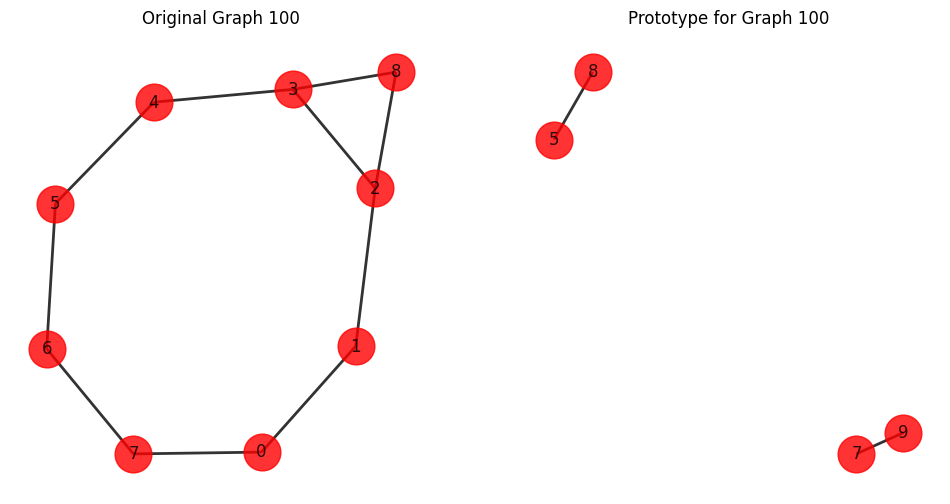

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


# Function to plot the original and denoised (prototype) graph
def explain_and_plot_graph(graph_idx, explainer, data, threshold=0.9):
    """
    Explain a graph and visualize both the original graph and its prototype (important subgraph).

    Args:
    - graph_idx: Index of the graph to explain.
    - explainer: The explainer instance.
    - data: PyTorch Geometric Data object containing the graph.
    - threshold: Threshold for denoising the graph (removing less important edges).
    """

    # Explain the graph and get the masked adjacency matrix
    masked_adj = explainer.explain_graphs(graph_indices=[graph_idx])[0]

    # Convert the PyG data object to a NetworkX graph for visualization
    original_G = to_networkx(data, to_undirected=True)

    # Get positions for the layout of the original graph
    pos = nx.spring_layout(original_G)

    # Plot 1: Original Graph
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    nx.draw(
        original_G,
        pos,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Original Graph {graph_idx}")

    # Plot 2: Denoised Prototype (Using denoise_graph)
    plt.subplot(1, 2, 2)

    # Use the denoise_graph function to filter important edges/nodes
    prototype_G = io_utils.denoise_graph(
        masked_adj,
        node_idx=0,  # Index of the central node
        feat=explainer.feat[graph_idx],
        threshold=threshold,  # Control how strict the filtering is
        max_component=False,
    )

    # Draw the prototype graph
    nx.draw(
        prototype_G,
        with_labels=True,
        node_color="red",
        edge_color="black",
        width=2,
        node_size=700,
        alpha=0.8,
    )
    plt.title(f"Prototype for Graph {graph_idx}")

    # Show both plots
    plt.show()


# Example usage
graph_idx = 100
data = pyg_dataset[graph_idx]  # Replace this with your dataset
plot_graph(data)
explain_and_plot_graph(graph_idx, explainer, data, 0.95)